In [1]:
import os
import joblib

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_train = pd.read_csv('../data/train.csv')
raw_test = pd.read_csv('../data/test.csv')

In [3]:
print(raw_train.info())
raw_train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6338 entries, 0 to 6337
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   6338 non-null   object 
 1   sex                  6338 non-null   object 
 2   Aged                 6338 non-null   object 
 3   Married              6338 non-null   object 
 4   TotalDependents      6338 non-null   object 
 5   ServiceSpan          6338 non-null   int64  
 6   MobileService        6338 non-null   object 
 7   4GService            6338 non-null   object 
 8   CyberProtection      6338 non-null   object 
 9   HardwareSupport      6338 non-null   object 
 10  TechnicalAssistance  6338 non-null   object 
 11  FilmSubscription     6338 non-null   object 
 12  SettlementProcess    6338 non-null   object 
 13  QuarterlyPayment     6338 non-null   float64
 14  GrandPayment         6328 non-null   float64
 15  CustomerAttrition    6338 non-null   o

,ID,sex,Aged,Married,TotalDependents,ServiceSpan,MobileService,4GService,CyberProtection,HardwareSupport,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment,CustomerAttrition
0,B60LHTZLLPFU4IULNPUF,Female,No,No,Yes,48,Yes,Wifi Broadband,No,Yes,Yes,No,Check,96.259802,4628.129119,Yes
1,1RUJ7ONYZHYTWKOKO1SD,Male,No,Yes,No,45,Yes,Wifi Broadband,No,No,No,Yes,Bank,18.876470,922.085998,No
2,DZ9EEOQWSN0MYCBUPAM5,Male,Yes,Yes,No,59,Yes,Wifi Broadband,Yes,No,Yes,No,Card,106.016057,6205.891129,Yes


In [4]:
print(raw_test.shape)
raw_test.head(2)

(705, 15)


,ID,sex,Aged,Married,TotalDependents,ServiceSpan,MobileService,4GService,CyberProtection,HardwareSupport,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment
0,WMORTPCG3HTIPEFSGUFY,Male,No,No,No,8,Yes,Wifi Broadband,No,No,No,Yes,Check,21.299937,151.092519
1,GBLPEA16C3KGBO57KEFO,Female,No,No,No,26,Yes,Satellite Broadband,No,Yes,No,Yes,Check,56.609623,1553.276979


In [5]:
combine = raw_train.append(raw_test).reset_index(drop=True)
combine.shape

(7043, 16)

In [6]:
combine.drop('ID', axis=1, inplace=True)

In [7]:
fill_value = combine['GrandPayment'].median()
combine['GrandPayment'] = combine['GrandPayment'].fillna(fill_value)

In [8]:
serv_span_null_dict = combine.groupby(['sex', 'Aged', 'Married']).mean()['ServiceSpan'].T.to_dict()

mask = combine['ServiceSpan'] < 0
serv_span_null_idx = combine.loc[mask].index.tolist()

for i in serv_span_null_idx:
    key = (combine.iloc[i, 0], combine.iloc[i, 1], combine.iloc[i, 2])
    combine['ServiceSpan'][i] = round(serv_span_null_dict[key])

In [9]:
combine['GrandPayment'] = np.sqrt(combine['GrandPayment'])

In [10]:
cat_cols = combine.select_dtypes(include='object').columns.tolist()
cat_cols.remove('CustomerAttrition')

ohe_cols = pd.get_dummies(combine[cat_cols], drop_first=True)

combine = combine.drop(cat_cols, axis=1)
combine = pd.concat([combine, ohe_cols], axis=1)

In [11]:
cat_cols = combine.select_dtypes(include='object').columns.tolist()
cat_cols.remove('CustomerAttrition')

for col in cat_cols:
    le = LabelEncoder()
    combine[col] = le.fit_transform(combine[col])

In [12]:
print(combine.shape)
combine.head(5)

(7043, 18)


,ServiceSpan,QuarterlyPayment,GrandPayment,CustomerAttrition,sex_Male,Aged_Yes,Married_Yes,TotalDependents_Yes,MobileService_Yes,4GService_Satellite Broadband,4GService_Wifi Broadband,CyberProtection_Yes,HardwareSupport_Yes,TechnicalAssistance_Yes,FilmSubscription_Yes,SettlementProcess_Card,SettlementProcess_Check,SettlementProcess_Electronic
0,48,96.259802,68.030354,Yes,0,0,0,1,1,0,1,0,1,1,0,0,1,0
1,45,18.876470,30.365869,No,1,0,1,0,1,0,1,0,0,0,1,0,0,0
2,59,106.016057,78.777479,Yes,1,1,1,0,1,0,1,1,0,1,0,1,0,0
3,14,80.108839,35.336318,No,1,0,0,0,1,0,1,0,0,0,0,0,1,0
4,25,51.529773,35.851378,No,0,0,1,1,1,0,1,0,1,0,1,0,1,0


In [14]:
target_col = 'CustomerAttrition'
mask = combine[target_col].isna() == True

train = combine.loc[~mask]
train[target_col] = train[target_col].replace({'Yes': 1, 'No': 0})

test = combine.loc[mask].drop(target_col, axis=1)

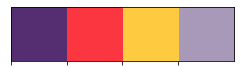

In [15]:
colors = ['#542e71', '#fb3640', '#fdca40', '#a799b7']
sns.palplot(colors)

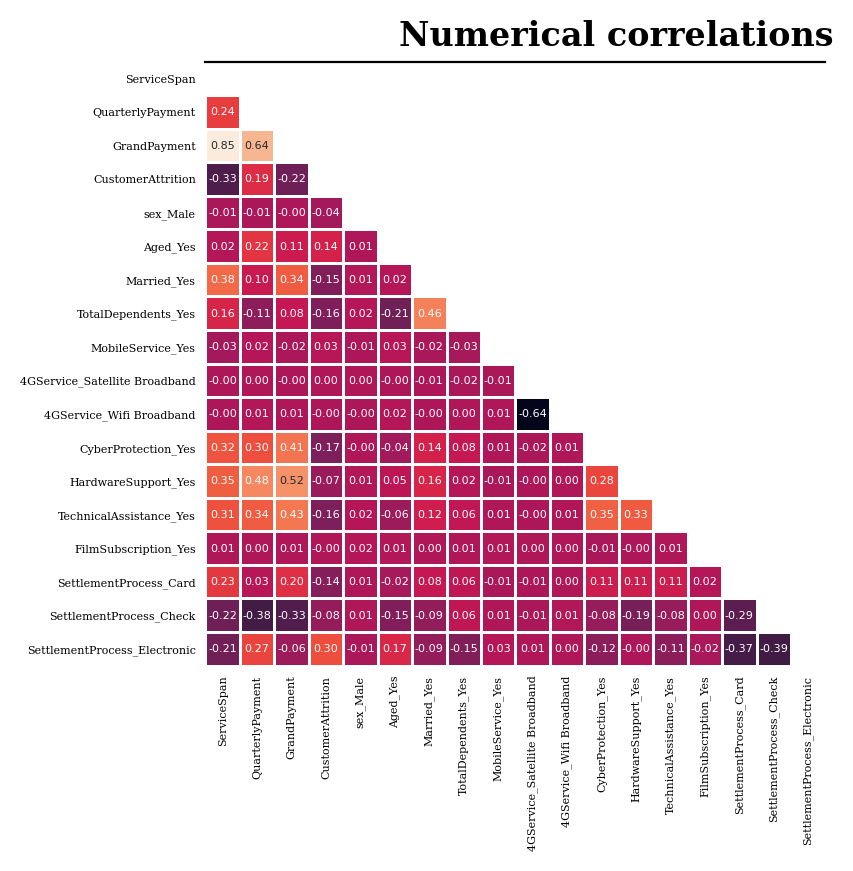

In [18]:
corr = train.corr()

# Setting up figure and axes
fig = plt.figure(figsize=(4, 4), dpi=200) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0.8)
ax0 = fig.add_subplot(gs[0, 0]) # create axis

mask = np.triu(corr)
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(corr, mask=mask, annot=True, cbar=False, fmt='.2f',
            linewidths=0.5, ax=ax0, annot_kws={'fontsize': 4})

ax0.set_yticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation = 0, fontsize=4)
ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=4)

ax0.spines['top'].set_visible(True)
ax0.tick_params(axis='both', which='both', length=0)

fig.text(0.91, 0.90, 'Numerical correlations', fontweight='bold', 
         fontfamily='serif', fontsize=12, ha='right')
# fig.text(0.91, 0.88, '''
# We observe here that performance 
# in one area is strongly correlated 
# to peformance in other areas.
# It is also interesting how
# negatively correlated free lunches 
# are with performance, 
# speaking to parental 
# socio-economic status.''', 
#          fontweight='light', fontfamily='serif', fontsize=6, va='top', ha='right')

plt.tight_layout()
plt.show()

In [95]:
train.head(3)

,sex,Aged,Married,TotalDependents,ServiceSpan,MobileService,4GService,CyberProtection,HardwareSupport,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment,CustomerAttrition
0,0,0,0,1,48,1,2,0,1,1,0,2,96.259802,68.030354,1
1,1,0,1,0,45,1,2,0,0,0,1,0,18.876470,30.365869,0
2,1,1,1,0,59,1,2,1,0,1,0,1,106.016057,78.777479,1


In [96]:
test.head(3)

,sex,Aged,Married,TotalDependents,ServiceSpan,MobileService,4GService,CyberProtection,HardwareSupport,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment
6338,1,0,0,0,8,1,2,0,0,0,1,2,21.299937,12.291970
6339,0,0,0,0,26,1,1,0,1,0,1,2,56.609623,39.411635
6340,1,0,0,0,66,1,1,0,0,0,1,1,25.167690,41.039766


In [97]:
train.to_csv('../data/clean_train2.csv', index=False)
test.to_csv('../data/clean_test2.csv', index=False)

In [2]:
705 * 0.75

528.75

In [101]:
705 - 516

189